In [187]:
import numpy as np
import math
from scipy import integrate
import itertools as itr
from common.ffn.ffn_relu import ParametricReLUNet
from common.ffn.ffn_base import FFNGmetricLogging
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from enum import Enum

ExpCalcMethod = Enum('ExpCalcMethod', ['SCIPY', 'SAMPLE_AVG'])

***
##### Theoretical values
***
For calculation expressions check formulas (1) - (6) in init_distribution_recursion_ffn_tanh.ipynb

***
##### Case: theoretical values for 2-point train set; all α and β are from [1,2]. Input dim is 100, all layer widths are 100; number of layers is 40. Activation function is hyperbolic tangent.
***
Experiment and FFN parameters:

In [188]:
'''n0: # dimension of x
    nk: # dimension of hidden layers
    nl: # dimension of output layer
    ln: # number of layers
    nd: # number of points in train-set'''
n0,nk,nl,ln=1000,1000,1000,50
nd=2

CONST_M1=2
CONST_M2=2

'''Cb and Cw constants'''
slope_plus, slope_minus=1,1 #math.sqrt(2), 0 #
#weights distribution variances are set as in (5.67)
cb, cw = 0, 2.0/(slope_plus**2.0 + slope_minus**2.0)
print("cb={}, cw={}".format(cb, cw))

'''Integration method settings'''
expCalcMethod = ExpCalcMethod.SAMPLE_AVG
CONST_EXP_SAMPLE_SIZE=1000000

'''experiments settings'''
experiments_number = 1000


cb=0, cw=1.0


Initialising trainset:

In [189]:
LOAD_TRAINSET_FROM_TRAINSET_CSV=True

if LOAD_TRAINSET_FROM_TRAINSET_CSV == True:
    if nd > 1:
        train_set = np.loadtxt("data/train-set.csv", delimiter=",")[:,:nd]
    else:
        train_set = np.expand_dims(np.loadtxt("data/train-set.csv", delimiter=","), axis=1)
else:
    #train_set = np.random.normal(loc=0.0, scale=1.0, size=(n0, nd)).astype(np.float32)
    train_set, _ = make_classification(n_samples=n0, n_features=nd, n_informative=nd, n_redundant=0, scale=1.0) #max(10, int(n0*0.2))
    np.savetxt("data/train-set.csv", train_set, delimiter=",")
if nd > 1:
    print(np.cov(train_set[:,0],train_set[:,1]))


[[ 1.82904576 -0.2106161 ]
 [-0.2106161   1.49298296]]


In [190]:
matrix_GG_top = np.zeros((ln, nd,nd))
matrix_GG_bottom = np.zeros_like(matrix_GG_top)
matrix_gg_top = np.zeros_like(matrix_GG_top)
matrix_gg_bottom = np.zeros_like(matrix_gg_top)
matrix_vv_top = np.zeros((ln,nd,nd,nd,nd))
matrix_vv_bottom = np.zeros_like(matrix_vv_top)

matrix_GG_only_top = np.zeros((ln, nd,nd))
matrix_GG_only_bottom = np.zeros_like(matrix_GG_only_top)
matrix_gg_only_top = np.zeros_like(matrix_GG_only_top)
matrix_gg_only_bottom = np.zeros_like(matrix_gg_only_top)


For calculation expressions of 1st layer preactivation check formulas (7) - (10) in init_distribution_recursion_ffn_tanh.ipynb

In [191]:
for aa_1 in range(0, nd):
    for aa_2 in range(0, aa_1+1):
        value = FFNGmetricLogging.G_xx(train_set[:,aa_1], train_set[:,aa_2], cb, cw)
        matrix_GG_bottom[0, aa_2, aa_1] = matrix_GG_bottom[0, aa_1, aa_2] = value

matrix_gg_only_bottom[0] = matrix_GG_only_bottom[0] = matrix_gg_bottom[0] = matrix_GG_bottom[0]
matrix_gg_only_top[0] = matrix_GG_only_top[0] = matrix_gg_top[0] = matrix_GG_top[0] = np.linalg.inv(matrix_GG_bottom[0])


In [192]:
print("Dims:{}".format(matrix_GG_bottom[0].shape))
print(np.linalg.det(matrix_GG_bottom[0]))
print(np.linalg.matrix_rank(matrix_GG_bottom[0]))
print(matrix_GG_bottom[0])
print(matrix_GG_top[0])

Dims:(2, 2)
2.6854275249283903
2
[[ 1.83010436 -0.21127964]
 [-0.21127964  1.49175461]]
[[0.55549986 0.07867635]
 [0.07867635 0.6814946 ]]


Preactivation on 2nd and subsequent layers $z^{(l)}$ is count by formulas (2)-(5)

In [193]:
aux = ParametricReLUNet()
aux.set_slopes(slope_plus, slope_minus)
#resultPReLU = aux.PReLUz(torch.tensor(np.array([1.1,-2.2]), dtype=torch.float32))

def_mean = [0]*nd
def_bounds = [[-100, 100]]*nd
def_opts=dict(epsabs=5e-02, epsrel=5e-02, limit=100)

def density(layer_zb, *args):
    return math.exp(-0.5*np.dot(np.dot(args, matrix_gg_top[layer_zb]), args))

def z_joint_bottom(layer_zb, bb_1_zb, bb_2_zb, args):
    return args[bb_1_zb]*args[bb_2_zb]-matrix_gg_bottom[layer_zb,bb_1_zb, bb_2_zb]

def calc_GG_integral(layer_zb, aa_1, aa_2, GG_head, ZZ_g):
    #print("Calculating G-integral for aa: {},{}".format(aa_1,aa_2))
    GG_integral = 0.0
    if expCalcMethod == ExpCalcMethod.SCIPY:
        GG_integral = (integrate.nquad\
            ( lambda *args: density(layer_zb, *args)*aux.PReLUz(args[aa_1])*aux.PReLUz(args[aa_2])\
            , def_bounds, opts=def_opts)/ZZ_g)[0]
    elif expCalcMethod == ExpCalcMethod.SAMPLE_AVG:
        pts = np.random.multivariate_normal(def_mean, matrix_gg_bottom[layer_zb], size=CONST_EXP_SAMPLE_SIZE)
        buff = [aux.PReLUz(val[aa_1])*aux.PReLUz(val[aa_2]) for val in pts]
        GG_integral = np.average(buff)
    else:
        Exception("Expected value calculation method undetermined")
    GG_head[aa_1,aa_2]=GG_head[aa_2,aa_1]=GG_integral
    #print("Calculating G-integral is finished for aa: {},{}".format(aa_1,aa_2))
    return GG_integral

def calc_integral_sigmaz3(layer_zb, aa_1,aa_2,bb_1,bb_2, sigmaz3, ZZ_g):
    #print("Calculating 4-index integral for aa/bb: {},{},{},{}".format(aa_1,aa_2,bb_1,bb_2))
    integral_sigmaz3 = 0.0
    if expCalcMethod == ExpCalcMethod.SCIPY:
        integral_sigmaz3 = (integrate.nquad\
            ( lambda *args: density(layer_zb, *args)*aux.PReLUz(args[aa_1])*aux.PReLUz(args[aa_2])*z_joint_bottom(layer_zb, bb_1, bb_2, args)
            , def_bounds, opts=def_opts)/ZZ_g)[0]
    elif expCalcMethod == ExpCalcMethod.SAMPLE_AVG:
        pts = np.random.multivariate_normal(def_mean, matrix_gg_bottom[layer_zb], size=CONST_EXP_SAMPLE_SIZE)
        buff = [aux.PReLUz(val[aa_1])*aux.PReLUz(val[aa_2])*z_joint_bottom(layer_zb, bb_1, bb_2, val) for val in pts]
        integral_sigmaz3 = np.average(buff)
    else:
        Exception("Expected value calculation method undetermined")
    sigmaz3[aa_1,aa_2,bb_1,bb_2]=sigmaz3[aa_1,aa_2,bb_2,bb_1]=sigmaz3[aa_2,aa_1,bb_1,bb_2]=sigmaz3[aa_2,aa_1,bb_2,bb_1]= integral_sigmaz3
    return integral_sigmaz3

def calc_integral_sigmaz4(layer_zb, aa_1,aa_2,bb_1,bb_2,bb_3,bb_4, sigmaz4, ZZ_g):
    #print("Calculating 6-index integral for aa/bb: {},{},{},{},{},{}".format(aa_1,aa_2,bb_1,bb_2,bb_3,bb_4))
    integral_sigmaz4 = 0.0
    if expCalcMethod == ExpCalcMethod.SCIPY:
        integral_sigmaz4 = (integrate.nquad\
            ( lambda *args: density(layer_zb, *args)*aux.PReLUz(args[aa_1])*aux.PReLUz(args[aa_2])\
                *z_joint_bottom(layer_zb, bb_1, bb_2, args)*z_joint_bottom(layer_zb, bb_3, bb_4, args)
            , def_bounds, opts=def_opts)/ZZ_g)[0]
    elif expCalcMethod == ExpCalcMethod.SAMPLE_AVG:
        pts = np.random.multivariate_normal(def_mean, matrix_gg_bottom[layer_zb], size=CONST_EXP_SAMPLE_SIZE)
        buff = [aux.PReLUz(val[aa_1])*aux.PReLUz(val[aa_2])\
                *z_joint_bottom(layer_zb, bb_1, bb_2, val)*z_joint_bottom(layer_zb, bb_3, bb_4, val) for val in pts]
        integral_sigmaz4 = np.average(buff)
    else:
        Exception("Expected value calculation method undetermined")
    sigmaz4[aa_1,aa_2,bb_1,bb_2,bb_3,bb_4] = sigmaz4[aa_1,aa_2,bb_2,bb_1,bb_3,bb_4] =\
    sigmaz4[aa_1,aa_2,bb_1,bb_2,bb_4,bb_3] = sigmaz4[aa_1,aa_2,bb_2,bb_1,bb_4,bb_3] =\
    sigmaz4[aa_1,aa_2,bb_3,bb_4,bb_1,bb_2] = sigmaz4[aa_1,aa_2,bb_3,bb_4,bb_2,bb_1] =\
    sigmaz4[aa_1,aa_2,bb_4,bb_3,bb_1,bb_2] = sigmaz4[aa_1,aa_2,bb_4,bb_3,bb_2,bb_1] =\
    sigmaz4[aa_2,aa_1,bb_1,bb_2,bb_3,bb_4] = sigmaz4[aa_2,aa_1,bb_2,bb_1,bb_3,bb_4] =\
    sigmaz4[aa_2,aa_1,bb_1,bb_2,bb_4,bb_3] = sigmaz4[aa_2,aa_1,bb_2,bb_1,bb_4,bb_3] =\
    sigmaz4[aa_2,aa_1,bb_3,bb_4,bb_1,bb_2] = sigmaz4[aa_2,aa_1,bb_3,bb_4,bb_2,bb_1] =\
    sigmaz4[aa_2,aa_1,bb_4,bb_3,bb_1,bb_2] = sigmaz4[aa_2,aa_1,bb_4,bb_3,bb_2,bb_1] =\
    integral_sigmaz4
    return integral_sigmaz4

def calc_integral4(layer_zb, aa_1,aa_2,aa_3,aa_4,ZZ_g):
    integral4 = 0.0
    if expCalcMethod == ExpCalcMethod.SCIPY:
        integral4 = (integrate.nquad\
            ( lambda *args: density(layer_zb, *args)*aux.PReLUz(args[aa_1])*aux.PReLUz(args[aa_2])*aux.PReLUz(args[aa_3])*aux.PReLUz(args[aa_4])\
            , [[-10, 10]]*nd, opts=dict(epsabs=5e-02, epsrel=5e-02, limit=100))/ZZ_g)[0]
    elif expCalcMethod == ExpCalcMethod.SAMPLE_AVG:
        pts = np.random.multivariate_normal(def_mean, matrix_gg_bottom[layer_zb], size=CONST_EXP_SAMPLE_SIZE)
        buff = [aux.PReLUz(val[aa_1])*aux.PReLUz(val[aa_2])*aux.PReLUz(val[aa_3])*aux.PReLUz(val[aa_4]) for val in pts]
        integral4 = np.average(buff)
    else:
        Exception("Expected value calculation method undetermined")
    return integral4


FeedForwardNet created with n0=3, nk=10, nl=3, l=3, bias_on=False


In [194]:
CALCULATE_GXX_ONLY=False

indices = range(0, nd)
layer_zb = 0
layer_next_zb = layer_zb+1
print("Starting calculation, all indexes are zero-based")
while layer_next_zb < ln:
    print("Starting calculation for layer {}".format(layer_next_zb))
    gg_bottom = matrix_gg_bottom[layer_zb]
    ZZ_g = (((2*np.pi)**nd)*np.linalg.det(gg_bottom))**0.5
    print("ZZ_g={}".format(ZZ_g))
    GG_head = np.zeros((nd,nd))
    sigmaz3 = np.zeros((nd,nd,nd,nd))
    sigmaz4 = np.zeros((nd,nd,nd,nd,nd,nd))
    #print("Calculating G-coefficients with bottom indices")
    for aa_1 in indices:
        for aa_2 in range(0, aa_1+1):
            #print("Calculating G-coefficient for aa: {},{}".format(aa_1,aa_2))
            GG_integral=GG_head[aa_1,aa_2]
            if GG_integral == 0:
                GG_integral = calc_GG_integral(layer_zb, aa_1, aa_2, GG_head, ZZ_g)
            
            GG_tail = np.zeros((nd,nd,nd,nd))
            if CALCULATE_GXX_ONLY==False:
                for bb_x in list(itr.product(indices,indices,indices,indices)):
                    bb_1,bb_2,bb_3,bb_4 = bb_x[0],bb_x[1],bb_x[2],bb_x[3]
                    vv_top = matrix_vv_top[layer_zb, bb_1, bb_2, bb_3, bb_4]
                    if vv_top != 0: #check if on previous iteration vv was calculated, 'd be true from 2nd layer 
                        #print("Calculating G-term for bb: {},{},{},{}".format(bb_1,bb_2,bb_3,bb_4))
                        integral_sigmaz4 = sigmaz4[aa_1,aa_2,bb_1,bb_2,bb_3,bb_4]
                        if integral_sigmaz4 == 0:
                            integral_sigmaz4 = calc_integral_sigmaz4(layer_zb,aa_1,aa_2,bb_1,bb_2,bb_3,bb_4,sigmaz4,ZZ_g)
                        integral_sigmaz3 = sigmaz3[aa_1,aa_2,bb_1,bb_2]
                        if integral_sigmaz3 == 0:
                            integral_sigmaz3 = calc_integral_sigmaz3(layer_zb, aa_1,aa_2,bb_1,bb_2, sigmaz3, ZZ_g)
                        GG_tail[bb_1,bb_2,bb_3,bb_4] = vv_top*\
                            (integral_sigmaz4+2*CONST_M1*gg_bottom[bb_3, bb_4]*integral_sigmaz3-2*GG_integral*\
                             gg_bottom[bb_1, bb_3]*gg_bottom[bb_2, bb_4])

            GG_bottom = GG_integral+np.sum(GG_tail)/8
            matrix_GG_bottom[layer_next_zb, aa_1, aa_2] = matrix_GG_bottom[layer_next_zb, aa_2, aa_1] = GG_bottom
            #GG_only
            matrix_GG_only_bottom[layer_next_zb, aa_1, aa_2] = matrix_GG_only_bottom[layer_next_zb, aa_2, aa_1] = GG_integral

    GG_top_next = matrix_GG_top[layer_next_zb] = np.linalg.inv(matrix_GG_bottom[layer_next_zb])
    #GG_only
    matrix_gg_only_bottom[layer_next_zb] = matrix_GG_only_bottom[layer_next_zb]
    matrix_gg_only_top[layer_next_zb] = matrix_GG_only_top[layer_next_zb] = np.linalg.inv(matrix_GG_only_bottom[layer_next_zb])
    
    if CALCULATE_GXX_ONLY==False:
        #print("Calculating v-coefficients with bottom indices")
        for aa_x in list(itr.product(indices,indices,indices,indices)):
            aa_1,aa_2,aa_3,aa_4 = aa_x[0],aa_x[1],aa_x[2],aa_x[3]
            #print("Calculating vv_coefficient for aa: {},{},{},{}".format(aa_1,aa_2,aa_3,aa_4))
            #print("Calculating v-integral for aa: {},{},{},{}".format(aa_1,aa_2,aa_3,aa_4))
            vv_integral4 = calc_integral4(layer_zb,aa_1,aa_2,aa_3,aa_4,ZZ_g)
            vv_integral2_12 = GG_head[aa_1,aa_2]
            if vv_integral2_12 == 0:
                print("Warning! G-integral for aa: {},{} is zero. It was probably not calculated".format(aa_1,aa_2))
                vv_integral2_12 = calc_GG_integral(layer_zb,aa_1,aa_2,GG_head,ZZ_g)
            vv_integral2_34 = GG_head[aa_3,aa_4]
            if vv_integral2_34 == 0:
                print("Warning! G-integral for aa: {},{} is zero. It was probably not calculated".format(aa_3,aa_4))
                vv_integral2_34 = calc_GG_integral(layer_zb,aa_3,aa_4,GG_head,ZZ_g)
            vv_tail = np.zeros((nd,nd,nd,nd))
            for bb_x in list(itr.product(indices,indices,indices,indices)):
                bb_1,bb_2,bb_3,bb_4 = bb_x[0],bb_x[1],bb_x[2],bb_x[3]
                vv_top = matrix_vv_top[layer_zb, bb_1, bb_2, bb_3, bb_4]
                if vv_top != 0:
                    integral_sigmaz3_12 = sigmaz3[aa_1,aa_2,bb_1,bb_2]
                    if integral_sigmaz3_12 == 0:
                        print("Warning! 4-index integral for aa/bb: {},{},{},{} is zero. It was probably not calculated"\
                              .format(aa_1,aa_2,bb_1,bb_2))
                        integral_sigmaz3_12 = calc_integral_sigmaz3(layer_zb, aa_1,aa_2,bb_1,bb_2, sigmaz3, ZZ_g)
                    integral_sigmaz3_34 = sigmaz3[aa_3,aa_4,bb_3,bb_4]
                    if integral_sigmaz3_34 == 0:
                        print("Warning! 4-index integral for aa/bb: {},{},{},{} is zero. It was probably not calculated"\
                              .format(aa_3,aa_4,bb_3,bb_4))
                        integral_sigmaz3_34 = calc_integral_sigmaz3(layer_zb, aa_3,aa_4,bb_3,bb_4, sigmaz3, ZZ_g)
                    vv_tail[bb_1,bb_2,bb_3,bb_4]=vv_top*integral_sigmaz3_12*integral_sigmaz3_34

            matrix_vv_bottom[layer_next_zb,aa_1,aa_2,aa_3,aa_4] = (vv_integral4-vv_integral2_12*vv_integral2_34)/nk + np.sum(vv_tail)/4

        #print("Calculating g-coefficients with top indices")
        for aa_1 in indices:
            for aa_2 in range(0, aa_1+1):
                ##print("Calculating g-coefficient for aa: {},{}".format(aa_1,aa_2))
                vv_tail = np.zeros((nd,nd,nd,nd))
                for bb_x in list(itr.product(indices,indices,indices,indices)):
                    bb_1,bb_2,bb_3,bb_4 = bb_x[0],bb_x[1],bb_x[2],bb_x[3]
                    vv_tail[bb_1,bb_2,bb_3,bb_4] = matrix_vv_bottom[layer_next_zb,bb_1,bb_2,bb_3,bb_4]*GG_top_next[aa_1,bb_1]*\
                        (GG_top_next[bb_2,bb_3]*GG_top_next[bb_4,aa_2]+CONST_M2*GG_top_next[bb_2,aa_2]*GG_top_next[bb_3,bb_4]/2)
                
                gg_top = GG_top_next[aa_1,aa_2]+np.sum(vv_tail)
                matrix_gg_top[layer_next_zb,aa_1,aa_2]=matrix_gg_top[layer_next_zb,aa_2,aa_1]=gg_top
        matrix_gg_bottom[layer_next_zb] = np.linalg.inv(matrix_gg_top[layer_next_zb])

        #print("Calculating v-coefficients with top indices")
        for aa_x in list(itr.product(indices,indices,indices,indices)):
            aa_1,aa_2,aa_3,aa_4 = aa_x[0],aa_x[1],aa_x[2],aa_x[3]
            vv_tail = np.zeros((nd,nd,nd,nd))
            for bb_x in list(itr.product(indices,indices,indices,indices)):
                bb_1,bb_2,bb_3,bb_4 = bb_x[0],bb_x[1],bb_x[2],bb_x[3]
                vv_tail[bb_1,bb_2,bb_3,bb_4]=GG_top_next[aa_1,bb_1]*GG_top_next[aa_2,bb_2]*GG_top_next[aa_3,bb_3]*\
                    GG_top_next[aa_4,bb_4]*matrix_vv_bottom[layer_next_zb,bb_1,bb_2,bb_3,bb_4]
            matrix_vv_top[layer_next_zb,aa_1,aa_2,aa_3,aa_4]=np.sum(vv_tail)
    else:
        matrix_gg_bottom[layer_next_zb] = matrix_GG_bottom[layer_next_zb]
        matrix_gg_top[layer_next_zb] = matrix_GG_top[layer_next_zb]

    '''
    print("matrix_gg_bottom: {}".format(matrix_gg_bottom[layer_next_zb]))
    print("matrix_gg_bottom det: {}".format(np.linalg.det(matrix_gg_bottom[layer_next_zb])))
    print("matrix_gg_bottom rank: {}".format(np.linalg.matrix_rank(matrix_gg_bottom[layer_next_zb])))
    '''

    layer_zb += 1
    layer_next_zb += 1 


print("Calculation for for theoretical values finished")


Starting calculation, all indexes are zero-based
Starting calculation for layer 1
ZZ_g=10.296427986217306
Starting calculation for layer 2
ZZ_g=10.22210228472889
Starting calculation for layer 3
ZZ_g=10.170993057928923
Starting calculation for layer 4
ZZ_g=10.128052995952073
Starting calculation for layer 5
ZZ_g=10.108199195430405
Starting calculation for layer 6
ZZ_g=10.063760264337263
Starting calculation for layer 7
ZZ_g=10.02914300092507
Starting calculation for layer 8
ZZ_g=10.001798413151441
Starting calculation for layer 9
ZZ_g=9.99144499115393
Starting calculation for layer 10
ZZ_g=9.959892292856697
Starting calculation for layer 11
ZZ_g=9.921417979405641
Starting calculation for layer 12
ZZ_g=9.888339955962735
Starting calculation for layer 13
ZZ_g=9.858209899901642
Starting calculation for layer 14
ZZ_g=9.840064806733034
Starting calculation for layer 15
ZZ_g=9.826999197316203
Starting calculation for layer 16
ZZ_g=9.791031257648312
Starting calculation for layer 17
ZZ_g=9.76

***
##### Observed values
***

In [195]:
#Callback
#To save each layer preactivation
z0_records = []
if (nd > 1):
    z1_records = []
#Only values for 1-st neuron of each layer is saved
def aggregarePreactivation(zn):
    exp0_records.append(zn[0,0])
    if (nd > 1):
        exp1_records.append(zn[1,0])

testNet = ParametricReLUNet(n0=n0,nk=nk,nl=nl,l=ln)
testNet.set_slopes(slope_plus, slope_minus)
testNet.register_on_forward_step_preactiv_callback(aggregarePreactivation)
testNet.set_log_level("info")
if (nd > 1):
    testNet.set_gmetric_recording_indices([(1,1),(1,2),(2,2)])
else:
    testNet.set_gmetric_recording_indices([(1,1)])

yy = np.zeros((experiments_number, nl, nd))
G00_records = []
if (nd > 1):
    G11_records = []
    G01_records = []

#for each experiment re-initialisation of the weights with recalculation
for experiment_number in range(experiments_number):
    exp0_records = []
    if (nd > 1):
        exp1_records = []

    testNet.init_weights(cb, cw)
    res = testNet.forward(train_set)
    yy[experiment_number] = res
    G00_records.append(testNet.get_gmetric(1,1).copy())
    if (nd > 1):
        G11_records.append(testNet.get_gmetric(2,2).copy())
        G01_records.append(testNet.get_gmetric(1,2).copy())

    z0_records.append(exp0_records)
    if (nd > 1):
        z1_records.append(exp1_records)
    
    print('-', end='')

#Each layer preactivation result
z0records = np.asarray(z0_records)
if (nd > 1):
    z1records = np.asarray(z1_records)

FeedForwardNet created with n0=1000, nk=1000, nl=1000, l=50, bias_on=False
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [196]:
avex_g = f"Average experimental G-values"
samplecov_z=f"Sample-covariance values"
theor_g=f"Theoretical G-values"
theor_g_main=f"Theoretical G-values, main term only"
ex_g=f"Experimental G-values"
lavernum="Layer number (0-based number)"
values_g="G-metric values"
valueslogabs_g="G-metric logarithmic absolute values"
valueslog_g="G-metric logarithmic values"

GRAPH_FRAME=300


Text(0.5, 0.98, 'Params: n0=1000,nk=1000,nl=1000,ln=50,nd=2,cb=0,cw=1.0; relu params: slope_plus=1,slope_minus=1;experiments_number=1000,CONST_M1=2,CONST_M2=2')

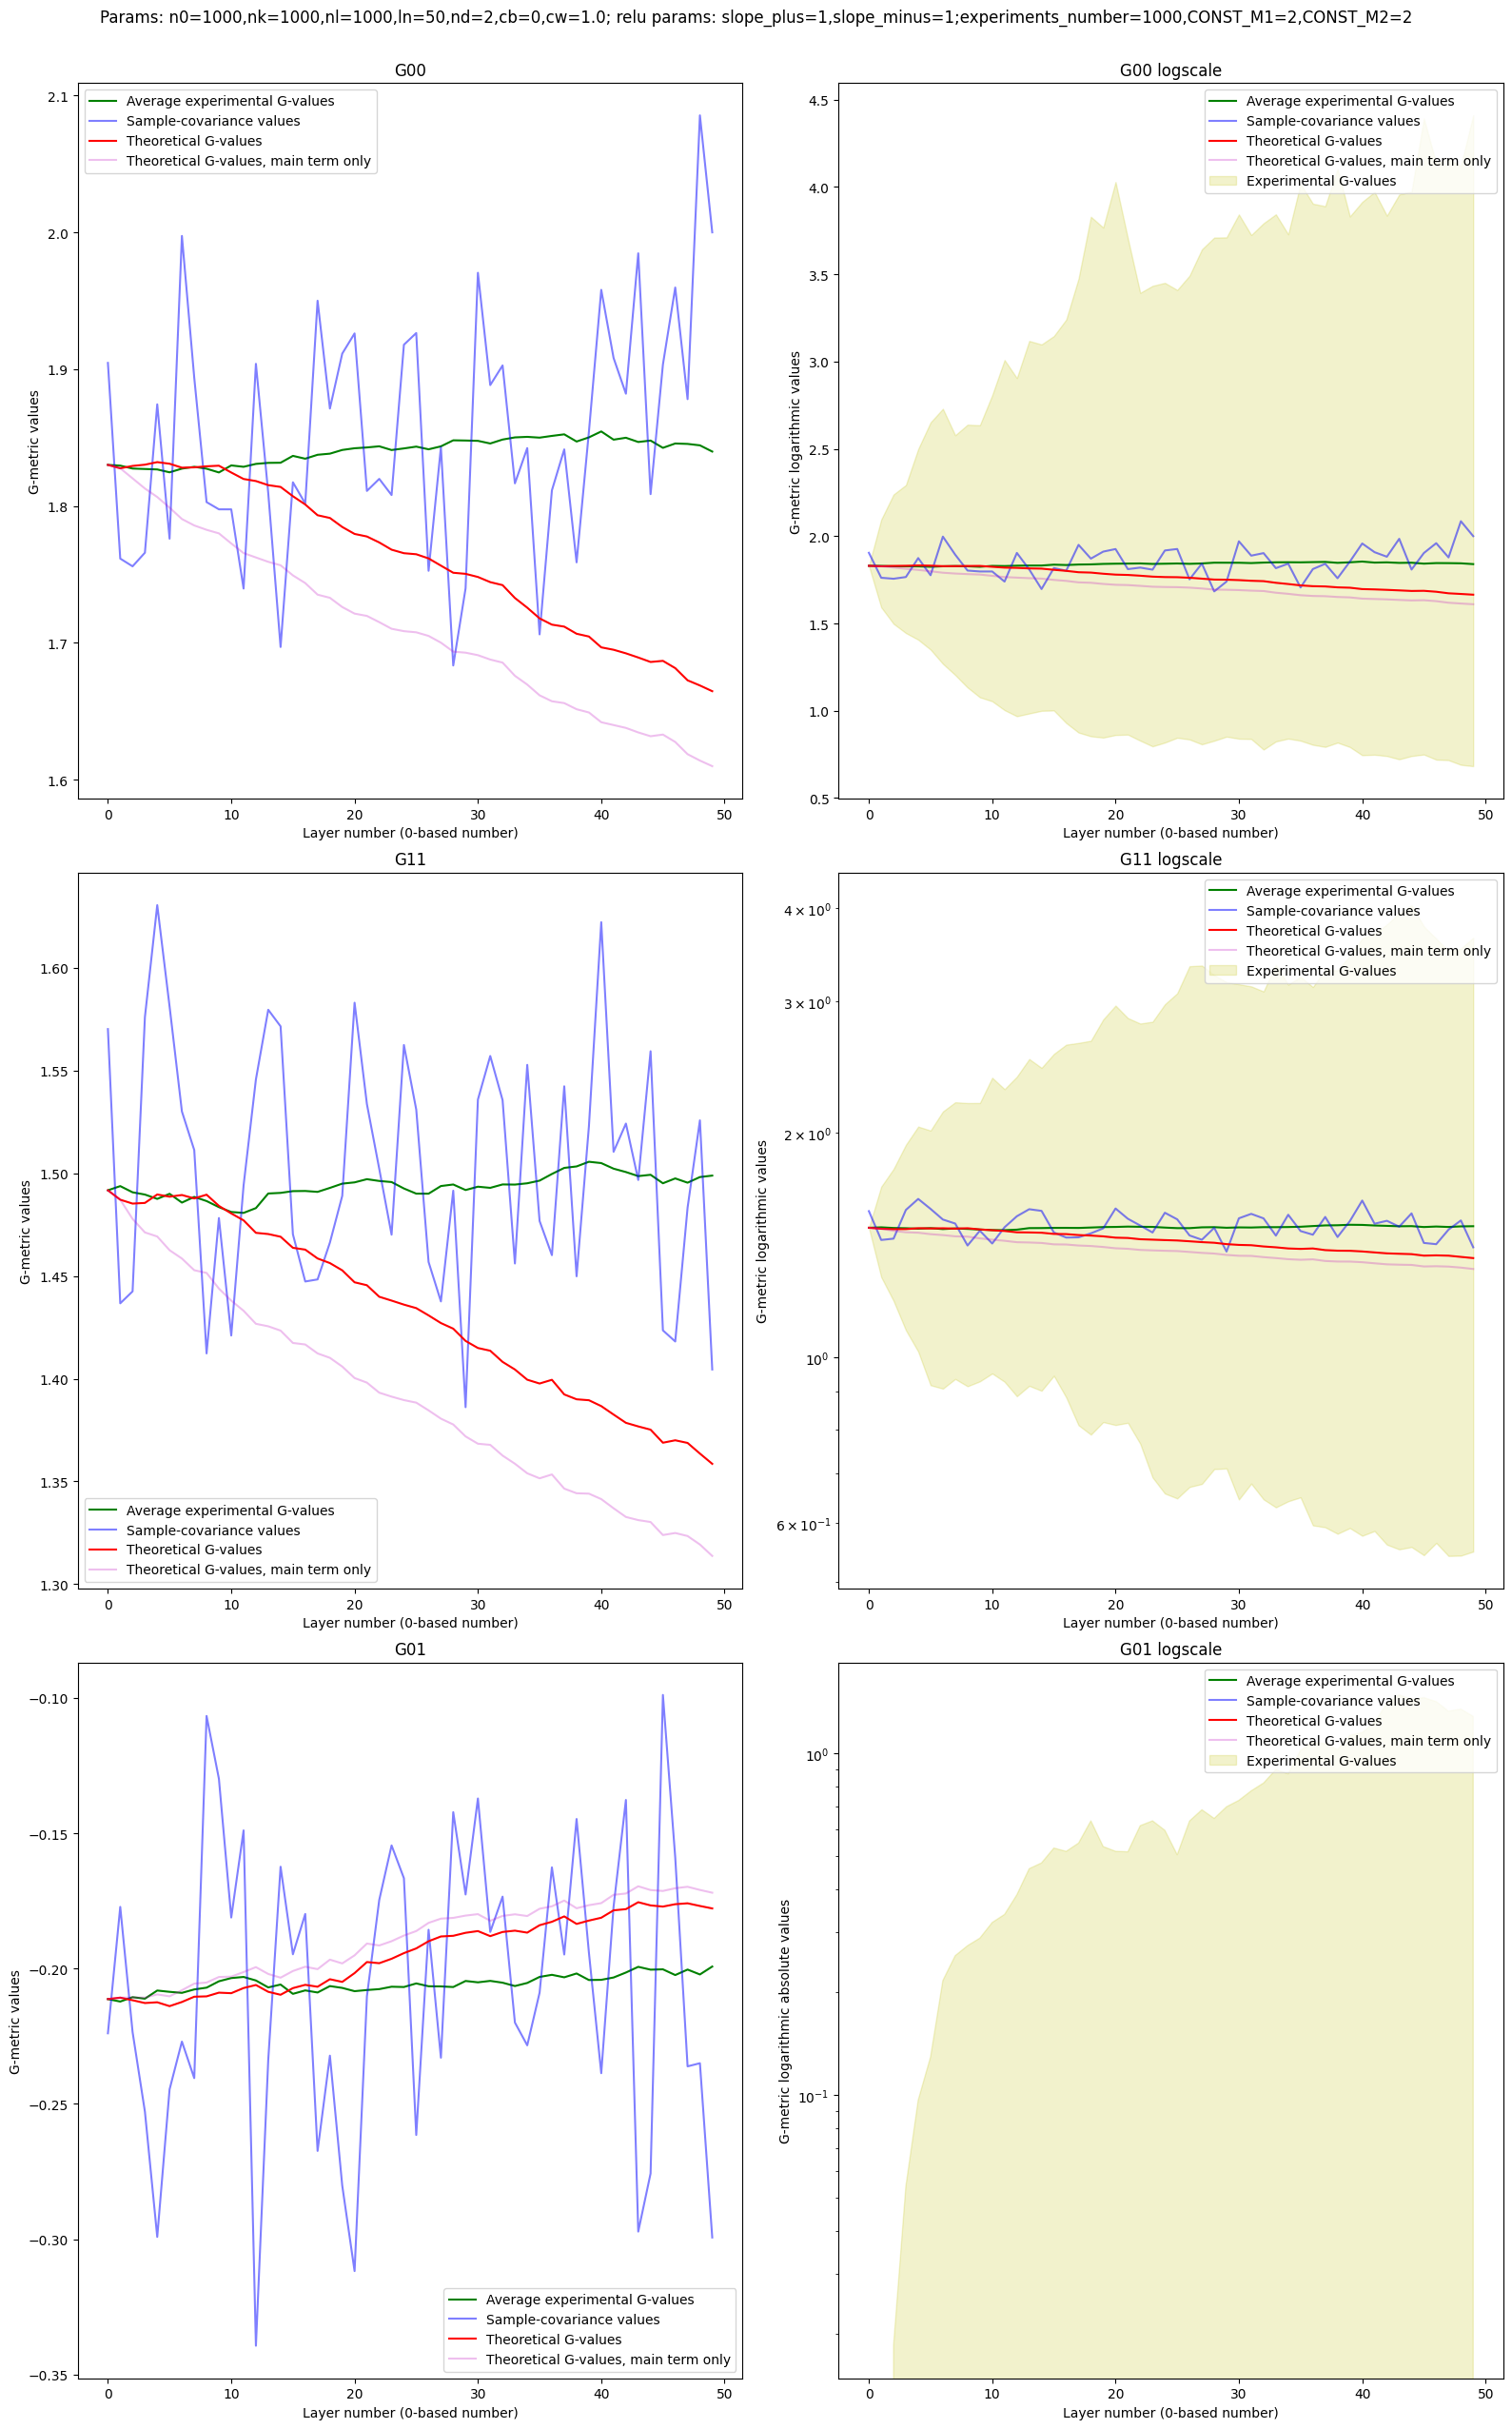

In [197]:
if (nd > 1):
    fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 26))
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

#for i, Gs in enumerate(G00_records):
#    ax1.plot(Gs, alpha=0.5, label=f"experiment {i}")

graphic_frame = min(GRAPH_FRAME, len(G00_records[0]))
G00_plot = np.asarray(G00_records)[:,0:graphic_frame]
cord_x = np.arange(0, len(G00_plot[0]))

G00_max = np.max(G00_plot, axis=0)
G00_min = np.min(G00_plot, axis=0)
G00_avg = np.average(G00_plot, axis=0)
G00_sample = []
for xx in cord_x:
    G00_sample.append(np.cov(z0records[:,xx],z0records[:,xx])[0,1])

ax1.plot(G00_avg, color='g', label=avex_g)
ax1.plot(G00_sample, color='b', alpha=0.5, label=samplecov_z)
ax1.plot(matrix_GG_bottom[:graphic_frame,0,0], color='r', label=theor_g)
ax1.plot(matrix_GG_only_bottom[:graphic_frame,0,0], color='m', alpha=0.25, label=theor_g_main)
#ax1.fill_between(x=cord_x, y1=G00_min, y2=G00_max, color='y', alpha=.2, label=ex_g)
ax1.set_xlabel(lavernum)
ax1.set_ylabel(values_g)
ax1.legend()
ax1.title.set_text("G00")

ax2.plot((G00_avg), color='g', label=avex_g)
ax2.plot((G00_sample), color='b', alpha=0.5, label=samplecov_z)
ax2.plot((matrix_GG_bottom[:graphic_frame,0,0]), color='r', label=theor_g)
ax2.plot((matrix_GG_only_bottom[:graphic_frame,0,0]), color='m', alpha=0.25, label=theor_g_main)
ax2.fill_between(x=cord_x, y1=(G00_min), y2=(G00_max), color='y', alpha=.2, label=ex_g)
ax2.set_xlabel(lavernum)
ax2.set_ylabel(valueslog_g)
ax4.set_yscale("log")
ax2.legend()
ax2.title.set_text("G00 logscale")

if (nd > 1):
    graphic_frame = min(GRAPH_FRAME, len(G11_records[0]))
    G11_plot = np.asarray(G11_records)[:,0:graphic_frame]
    cord_x = np.arange(0, len(G11_plot[0]))

    G11_max = np.max(G11_plot, axis=0)
    G11_min = np.min(G11_plot, axis=0)
    G11_avg = np.average(G11_plot, axis=0)
    G11_sample = []
    for xx in cord_x:
        G11_sample.append(np.cov(z1records[:,xx],z1records[:,xx])[0,1])    

    ax3.plot(cord_x, G11_avg, color='g', label=avex_g)
    ax3.plot(cord_x, G11_sample, color='b', alpha=0.5, label=samplecov_z)
    ax3.plot(cord_x, matrix_GG_bottom[:graphic_frame,1,1], color='r', label=theor_g)
    ax3.plot(cord_x, matrix_GG_only_bottom[:graphic_frame,1,1], color='m', alpha=0.25, label=theor_g_main)
    #ax3.fill_between(x=cord_x, y1=G11_min, y2=G11_max, color='y', alpha=.2, label=ex_g)
    ax3.set_xlabel(lavernum)
    ax3.set_ylabel(values_g)
    ax3.legend()
    ax3.title.set_text("G11")

    ax4.plot(cord_x, (G11_avg), color='g', label=avex_g)
    ax4.plot(cord_x, (G11_sample), color='b', alpha=0.5, label=samplecov_z)
    ax4.plot(cord_x, (matrix_GG_bottom[:graphic_frame,1,1]), color='r', label=theor_g)
    ax4.plot(cord_x, (matrix_GG_only_bottom[:graphic_frame,1,1]), color='m', alpha=0.25, label=theor_g_main)
    ax4.fill_between(x=cord_x, y1=(G11_min), y2=(G11_max), color='y', alpha=.2, label=ex_g)
    ax4.set_xlabel(lavernum)
    ax4.set_ylabel(valueslog_g)
    ax4.set_yscale("log")
    ax4.legend()
    ax4.title.set_text("G11 logscale")

    graphic_frame = min(GRAPH_FRAME, len(G01_records[0]))
    G01_plot = np.asarray(G01_records)[:,0:graphic_frame]
    cord_x = np.arange(0, len(G01_plot[0]))

    G01_max = np.max(G01_plot, axis=0)
    G01_min = np.min(G01_plot, axis=0)
    G01_avg = np.average(G01_plot, axis=0)
    cord_x = np.arange(0, len(G01_plot[0]))
    G01_sample = []
    for xx in cord_x:
        G01_sample.append(np.cov(z0records[:,xx],z1records[:,xx])[0,1])    

    ax5.plot(cord_x, G01_avg, color='g', label=avex_g)
    ax5.plot(cord_x, G01_sample, color='b', alpha=0.5, label=samplecov_z)
    ax5.plot(cord_x, matrix_GG_bottom[:graphic_frame,0,1], color='r', label=theor_g)
    ax5.plot(cord_x, matrix_GG_only_bottom[:graphic_frame,0,1], color='m', alpha=0.25, label=theor_g_main)
    #ax5.fill_between(x=cord_x, y1=((G01_min)), y2=((G01_max)), color='y', alpha=.2, label=ex_g)
    ax5.set_xlabel(lavernum)
    ax5.set_ylabel(values_g)
    ax5.legend()
    ax5.title.set_text("G01")

    ax6.plot(cord_x, ((G01_avg)), color='g', label=avex_g)
    ax6.plot(cord_x, ((np.asarray(G01_sample))), color='b', alpha=0.5, label=samplecov_z)
    ax6.plot(cord_x, ((matrix_GG_bottom[:graphic_frame,0,1])), color='r', label=theor_g)
    ax6.plot(cord_x, ((matrix_GG_only_bottom[:graphic_frame,0,1])), color='m', alpha=0.25, label=theor_g_main)
    ax6.fill_between(x=cord_x, y1=(G01_min), y2=(G01_max), color='y', alpha=.2, label=ex_g)
    ax6.set_xlabel(lavernum)
    ax6.set_ylabel(valueslogabs_g)
    ax6.set_yscale("log")
    ax6.legend()
    ax6.title.set_text("G01 logscale")

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle(f"Params: n0={n0},nk={nk},nl={nl},ln={ln},nd={nd},cb={cb},cw={cw}; \
relu params: slope_plus={slope_plus},slope_minus={slope_minus};experiments_number={experiments_number},\
CONST_M1={CONST_M1},CONST_M2={CONST_M2}")
#plt.show()

In [198]:
layer_zb = 0
gg_bottom = matrix_gg_bottom[layer_zb]
ZZ_g = (((2*np.pi)**nd)*np.linalg.det(gg_bottom))**0.5
GG_head = np.zeros((nd,nd))
ggg = calc_GG_integral(layer_zb,0,0,GG_head,ZZ_g)
print("integrate result:{}".format(ggg))


integrate result:1.8361580876903654


In [199]:
'''
pts = np.random.multivariate_normal([0, 0], gg_bottom, size=1000000)
buff = [aux.PReLUz(val[0])*aux.PReLUz(val[1]) for val in pts]
#buff = [val[0]*val[1] for val in pts]
print("average result:{}".format(np.average(buff)))
'''

'\npts = np.random.multivariate_normal([0, 0], gg_bottom, size=1000000)\nbuff = [aux.PReLUz(val[0])*aux.PReLUz(val[1]) for val in pts]\n#buff = [val[0]*val[1] for val in pts]\nprint("average result:{}".format(np.average(buff)))\n'

In [200]:
#print(pts[0,0], aux.PReLUz(pts[0,0]), aux.slope_positive, aux.slope_negative) #*pts[0,1]
#aux.PReLUz()
#train_set
gg_bottom = matrix_gg_bottom[0]
print(gg_bottom)
ZZ_g = (((2*np.pi)**nd)*np.linalg.det(gg_bottom))**0.5
ZZ_g

[[ 1.83010436 -0.21127964]
 [-0.21127964  1.49175461]]


10.296427986217306